<a href="https://colab.research.google.com/github/opsabarsec/Olist/blob/master/OList_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone RAPIDS AI rapidsai-csp-utils scripts repo
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git

# install RAPIDS
!bash rapidsai-csp-utils/colab/rapids-colab.sh

import sys, os
# set necessary environment variables 
dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path

# update pyarrow & modules 
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 89 (delta 19), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (89/89), done.
PLEASE READ
********************************************************************************************************
Changes:
1. Now that most people have migrated, we have rem0ved the migration notice.
2. default stable version is now 0.13.  Nightly is now 0.14
3. You can now declare your RAPIDS version as a CLI option and skip the user prompts (ex: '0.13' or '0.14', between 0.11 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/ra

In [2]:
import sys
!cp ../input/rapids/rapids.0.13.0 /opt/conda/envs/rapids.tar.gz > /dev/null
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.6"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/ > /dev/null

cp: cannot stat '../input/rapids/rapids.0.13.0': No such file or directory
/bin/bash: line 0: cd: /opt/conda/envs/: No such file or directory
cp: cannot stat '/opt/conda/envs/rapids/lib/libxgboost.so': No such file or directory


In [3]:
!pip install pyclustering

     |████████████████████████████████| 2.6 MB 3.4 MB/s 
     |████████████████████████████████| 12.4 MB 63.2 MB/s 
     |████████████████████████████████| 88 kB 9.8 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.9.3.1-py3-none-any.whl size=2599359 sha256=6e44d27d67ba33c32365deeff437279f4a0f639b55c7831efe120ff4b79e2bb8
  Stored in directory: /root/.cache/pip/wheels/20/23/2f/6c458c4771b29be048cda23e876061a6864ecfc7a9ae2ccf39
Successfully built pyclustering


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import cuml

In [0]:
from cuml.manifold import TSNE

In [7]:
# import the raw data from csv files
alldata = pd.read_csv('Main_OList_Data.csv',sep=',')
df_RFM = pd.read_csv('RFM_OList_Data.csv',sep=',')
print(alldata.shape, df_RFM.shape)

(96770, 10) (96770, 11)


# Unsupervised segmentation of the main dataframe

## 1 Clusteriung with K-means


In [0]:
alldata.columns
alldata= alldata.drop(['Unnamed: 0'], axis=1)

1.1 Variables selection

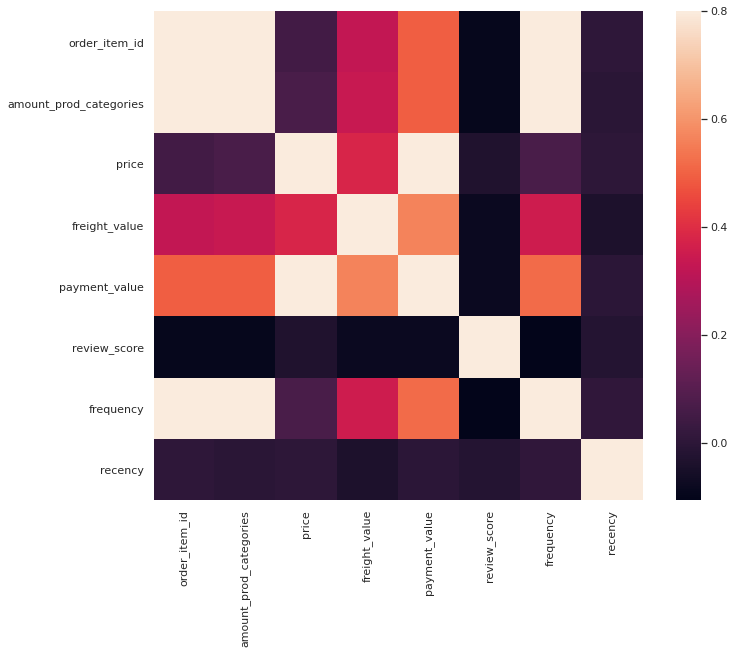

In [0]:
sns.set(style="white")
# Compute the correlation matrix
corrmat = alldata.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [0]:
grouping_variables = ['amount_prod_categories','payment_value', 'freight_value', 'review_score', 'recency'] 

In [0]:
df_reduced = alldata[grouping_variables]

the amount of product categories is correlated to the order_item_id. So the latter variable is suppressed for the grouping

Now a final exploration of variables distribution, visualized by a box plot

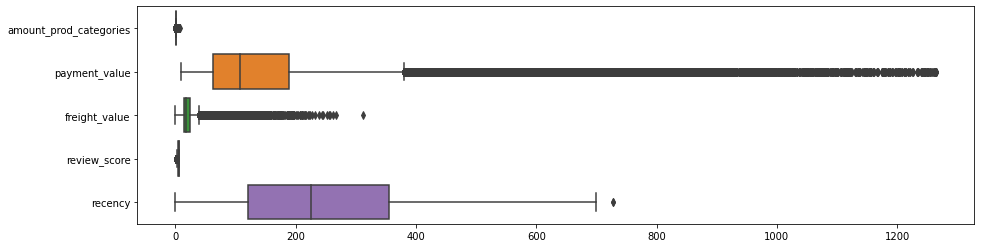

In [11]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_reduced, orient = "h")
plt.show()

### 1.1 Scaling

In [12]:
X = df_reduced.values

#scaler = preprocessing.StandardScaler()
#X_scaled = scaler.fit_transform(X) # variables normalized
#print(scaler.mean_)
#print(scaler.scale_)
X_scaled = scale(X)

print('X meanX',np.mean(X_scaled),',X standard deviation:',np.std(X_scaled), ".Ok, the features are scaled")

X meanX 8.399926523814763e-18 ,X standard deviation: 1.0 .Ok, the features are scaled


In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X_scaled)
X_scaled = imputer.transform(X_scaled)

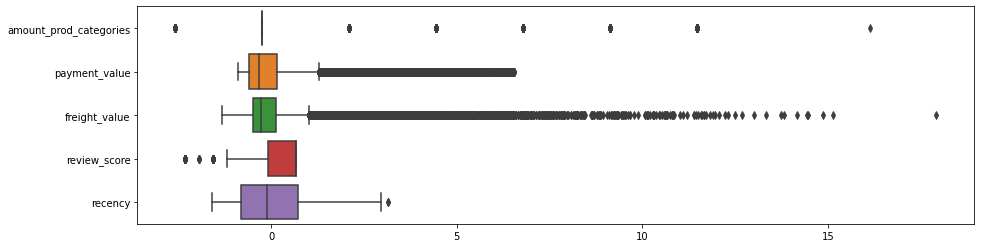

In [14]:
scaled_dataframe = pd.DataFrame( X_scaled, columns = df_reduced.columns )
plt.figure(figsize = (15,4))
sns.boxplot(data = scaled_dataframe, orient = "h")
plt.show()

In [15]:
print(X_scaled.shape)

(96770, 5)


In [16]:
null = np.isnan(X_scaled)
print(null)

[[False False False False False]
 [False False False False False]
 [False False False False False]
 ...
 [False False False False False]
 [False False False False False]
 [False False False False False]]


### 1.2 Create test and train set

In [17]:
train_size = int(len(X) * 0.98)
X_train, X_test = X[0:train_size], X[train_size:len(X)]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(X_train)))
print('Testing Observations: %d' % (len(X_test)))

Observations: 96770
Training Observations: 94834
Testing Observations: 1936


### 1.3 K-means hyperparameters optimization 

In [0]:
Optimal number of cluster, based on  WCSS elbow method and gap coefficients

In [0]:
# statistical gap : make a function that gives both gap and silhouette values
# https://uc-r.github.io/kmeans_clustering#gap
from sklearn.cluster import KMeans
wcss_all = []
allgaps = []



def optimalK(data, nrefs=3, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(n_clusters = k, init="k-means++", random_state=10)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap, 'WSS 1e8':round(origDisp/100000000,1)}, ignore_index=True)
        allgaps.append(gap)
        wcss_all.append(origDisp)
    print(resultsdf)        
    return(resultsdf)
   
    #print(wcss_all)

In [0]:


resultsdf = optimalK(X_train, nrefs=3, maxClusters=10)#.apply(lambda x: x.split(',')['clusterCount'])

   clusterCount        gap  WSS 1e8
0           1.0 -11.741679     49.7
1           2.0 -11.440892     31.2
2           3.0 -10.937830     16.9
3           4.0 -10.809074     13.4
4           5.0 -10.621098     10.2
5           6.0 -10.546283      8.8
6           7.0 -10.475642      7.7
7           8.0 -10.416018      6.8
8           9.0 -10.370572      6.1


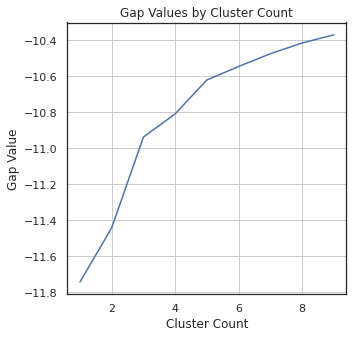

In [0]:
plt.figure(figsize=(5,5))
plt.plot(range(1,10), allgaps)
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

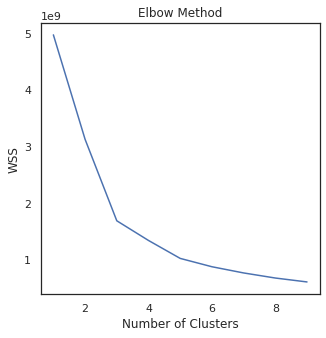

In [0]:
plt.figure(figsize=(5,5))
plt.plot(range(1, 10), wcss_all)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

According to the above graph 3 or 4 clusters should be the optimum value. 
Let's double check by calculating the silhouette coefficient for several clustering values

1.5 Optimal number of cluster, based on Silhouette coefficients estimation

In [0]:
k_means_silhouette = []
from sklearn.metrics import silhouette_samples, silhouette_score
for n_clusters in range(2,10):
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    k_means_silhouette.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,2) )

For n_clusters = 2 The average silhouette_score is : 0.56
For n_clusters = 3 The average silhouette_score is : 0.45
For n_clusters = 4 The average silhouette_score is : 0.45
For n_clusters = 5 The average silhouette_score is : 0.4
For n_clusters = 6 The average silhouette_score is : 0.4
For n_clusters = 7 The average silhouette_score is : 0.39
For n_clusters = 8 The average silhouette_score is : 0.36
For n_clusters = 9 The average silhouette_score is : 0.36


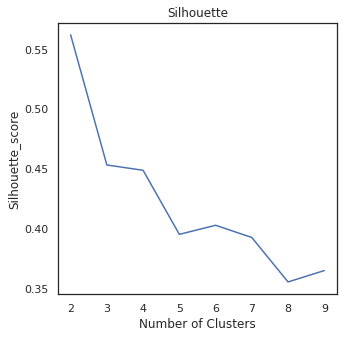

In [0]:
plt.figure(figsize=(5,5))
plt.plot(range(2, 10), k_means_silhouette)
plt.title('Silhouette')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette_score') #within cluster sum of squares
plt.show()

4 clusters has a high coeffiecient and is close to the WCSS elbow 

In [20]:
km = KMeans(n_clusters=4, init="random", random_state=10)
import time
time_start = time.time()
clusts_train = km.fit_predict(X_train)
print('K-Means done! Time elapsed: {} seconds'.format(time.time()-time_start))

K-Means done! Time elapsed: 1.083942174911499 seconds


In [21]:
clusts_test = np.zeros(len(X_test)) # creation of an "artificial" cluster value for the test set
clusts_test = clusts_test + 42
clusts_test

array([42., 42., 42., ..., 42., 42., 42.])

Creation of a numpy array that can be transformed to a cluster column

In [22]:
clust = np.concatenate((clusts_train, clusts_test), axis=None)
print(clusts_train.shape, clusts_test.shape ,clust.shape) # verify all is right shape

(94834,) (1936,) (96770,)


Creation of the dataframe that will be represented. Test data that have a special artificial cluster can now be joined back

In [0]:
df_train = pd.DataFrame.from_records(X_train)
df_test = pd.DataFrame.from_records(X_test)

In [24]:
df_clustered = pd.concat([df_train, df_test])#, ignore_index=True)
df_clustered.head()

,0,1,2,3,4
0,8.0,992.96,93.84,5.0,288.0
1,6.0,1252.08,76.74,1.0,170.0
2,6.0,426.60,47.22,5.0,9.0
3,6.0,774.18,84.66,5.0,692.0
4,6.0,1157.04,61.24,5.0,112.0


 ### 1.4.1 KM-clusters representation in 2D using PCA

In [25]:
from sklearn.decomposition import PCA
pca_feat = PCA(n_components=2)
time_start = time.time()
X_PCA = pca_feat.fit_transform(df_clustered)
print(pca_feat.explained_variance_ratio_)
# Plot the explained variances
features = range(pca_feat.n_components_)
print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

[0.54576988 0.45078097]
PCA done! Time elapsed: 0.06563210487365723 seconds


In [26]:
df_PCA = pd.DataFrame.from_records(X_PCA)
clust_series = pd.Series(clust)
clust_series.head()

0    1.0
1    1.0
2    3.0
3    1.0
4    1.0
dtype: float64

In [27]:
df_PCA = df_PCA.assign(cluster = clust_series)

df_PCA.columns

Index([0, 1, 'cluster'], dtype='object')

In [28]:
df_PCA = df_PCA.rename(columns={0: 'PCA_1', 1: 'PCA_2'})
df_PCA["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 42: "Test values"}, inplace=True)
df_PCA.head()

,PCA_1,PCA_2,cluster
0,832.699107,51.037656,Cluster 2
1,1091.605743,-64.378500,Cluster 2
2,267.318904,-233.303386,Cluster 4
3,609.901255,452.918387,Cluster 2
4,996.413936,-123.249609,Cluster 2


In [29]:
df_PCA = df_PCA.dropna()
print(df_PCA.columns, df_PCA.shape)

Index(['PCA_1', 'PCA_2', 'cluster'], dtype='object') (96770, 3)


/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


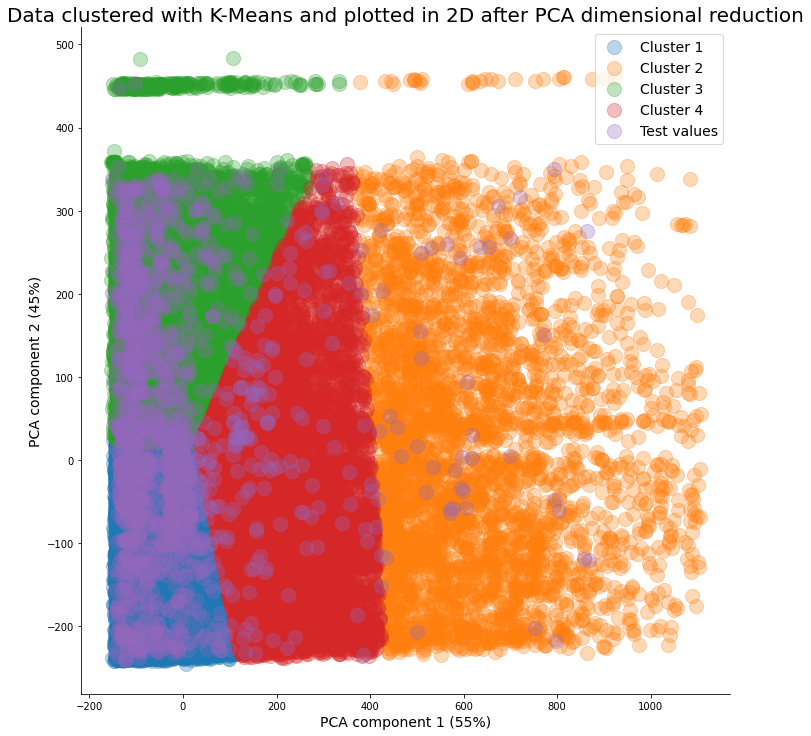

In [30]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Test values']
sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = df_PCA, fit_reg = False, legend = False, size = 10, hue = "cluster", hue_order= orderhue, scatter_kws={"s":200, "alpha":0.3} )
plt.xlabel('PCA component 1 (55%)', fontsize = 14)
plt.ylabel('PCA component 2 (45%)', fontsize = 14)
plt.title('Data clustered with K-Means and plotted in 2D after PCA dimensional reduction', fontsize = 20)
plt.legend(fontsize = 14)
plt.show()

### 1.4.2 KM-clusters representation in 2D using T-SNE algorythm 

In [0]:
tsne = TSNE(n_components=2, perplexity=31, random_state=2020 )

In [0]:
# create a numpy matrix by concatenation of train and test datasets
X_concat = df_clustered.values#np.concatenate((X_train, X_test), axis=None)

In [39]:
import time
time_start = time.time()

X_TSNE = tsne.fit_transform(X_concat)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


t-SNE done! Time elapsed: 4.414096832275391 seconds


In [40]:
df_TSNE = pd.DataFrame.from_records(X_TSNE)
print(df_TSNE.shape)
df_TSNE.head()

(96770, 2)


,0,1
0,12.408204,82.721779
1,6.299145,82.441940
2,69.431808,18.749945
3,22.566423,71.934090
4,6.599555,83.855850


In [0]:
clust_series = pd.Series(clust)

In [42]:
df_TSNE = df_TSNE.assign(cluster = clust_series)

print(df_TSNE.columns, df_TSNE.shape)
df_TSNE = df_TSNE.rename(columns={0: 'TSNE_1', 1: 'TSNE_2'})
df_TSNE["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 42: "Test values"}, inplace=True)
df_TSNE.head()

Index([0, 1, 'cluster'], dtype='object') (96770, 3)


,TSNE_1,TSNE_2,cluster
0,12.408204,82.721779,Cluster 2
1,6.299145,82.441940,Cluster 2
2,69.431808,18.749945,Cluster 4
3,22.566423,71.934090,Cluster 2
4,6.599555,83.855850,Cluster 2


In [43]:
df_TSNE["cluster"].value_counts()

Cluster 1      45544
Cluster 3      33796
Cluster 4      11478
Cluster 2       4016
Test values     1936
Name: cluster, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


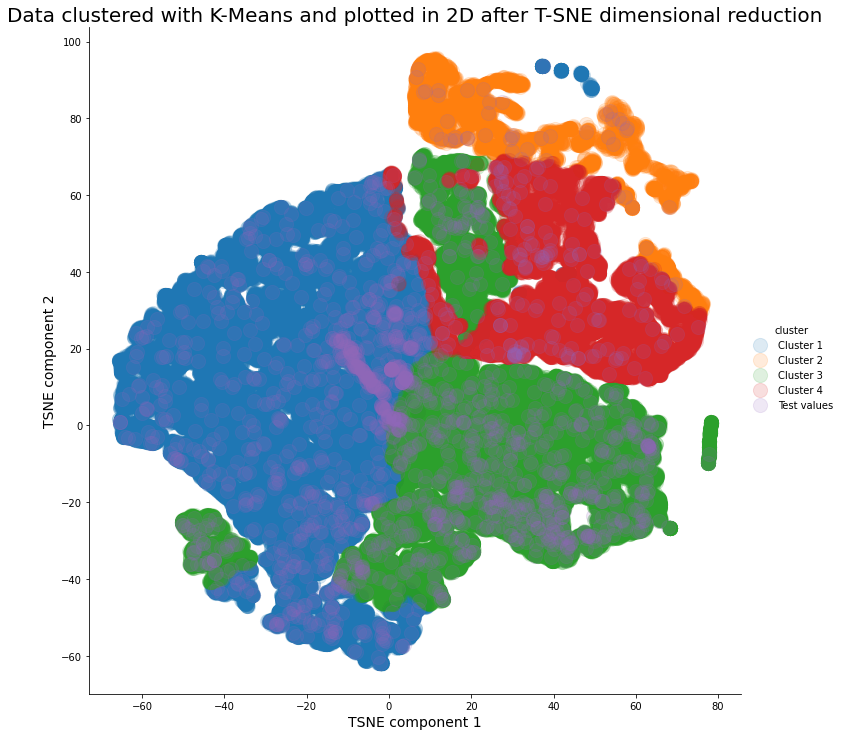

In [44]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Test values']
sns.lmplot(x = 'TSNE_1', y = 'TSNE_2', data = df_TSNE, fit_reg = False, legend = True, size = 10, hue = "cluster", hue_order= orderhue, scatter_kws={"s":200, "alpha":0.15} )
plt.xlabel('TSNE component 1', fontsize = 14)
plt.ylabel('TSNE component 2', fontsize = 14)
plt.title('Data clustered with K-Means and plotted in 2D after T-SNE dimensional reduction', fontsize = 20)
plt.show()

### 1.5 Boxplot for each feature

In [45]:
df_clustered_labeled = df_clustered.assign(cluster = clust_series)
df_clustered_labeled.head()


,0,1,2,3,4,cluster
0,8.0,992.96,93.84,5.0,288.0,1.0
1,6.0,1252.08,76.74,1.0,170.0,1.0
2,6.0,426.60,47.22,5.0,9.0,3.0
3,6.0,774.18,84.66,5.0,692.0,1.0
4,6.0,1157.04,61.24,5.0,112.0,1.0


In [46]:
df_clustered_labeled.cluster.unique()

array([1., 3., 2., 0.])

In [47]:
columnsvector = df_reduced.columns
print(columnsvector)
df_train_labeled = df_train
df_train_labeled.columns = columnsvector



Index(['amount_prod_categories', 'payment_value', 'freight_value',
       'review_score', 'recency'],
      dtype='object')


In [48]:
df_train_labeled = df_train_labeled.assign(cluster = clusts_train)
df_train_labeled["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4"}, inplace=True)
df_train_labeled.head()

,amount_prod_categories,payment_value,freight_value,review_score,recency,cluster
0,8.0,992.96,93.84,5.0,288.0,Cluster 2
1,6.0,1252.08,76.74,1.0,170.0,Cluster 2
2,6.0,426.60,47.22,5.0,9.0,Cluster 4
3,6.0,774.18,84.66,5.0,692.0,Cluster 2
4,6.0,1157.04,61.24,5.0,112.0,Cluster 2


In [0]:
x1 = df_train_labeled["cluster"]
y0 = df_train_labeled[df_train_labeled.columns[0]]
y1 = df_train_labeled[df_train_labeled.columns[1]]
y2 = df_train_labeled[df_train_labeled.columns[2]]
y3 = df_train_labeled[df_train_labeled.columns[3]]
y4 = df_train_labeled[df_train_labeled.columns[4]]
order = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]


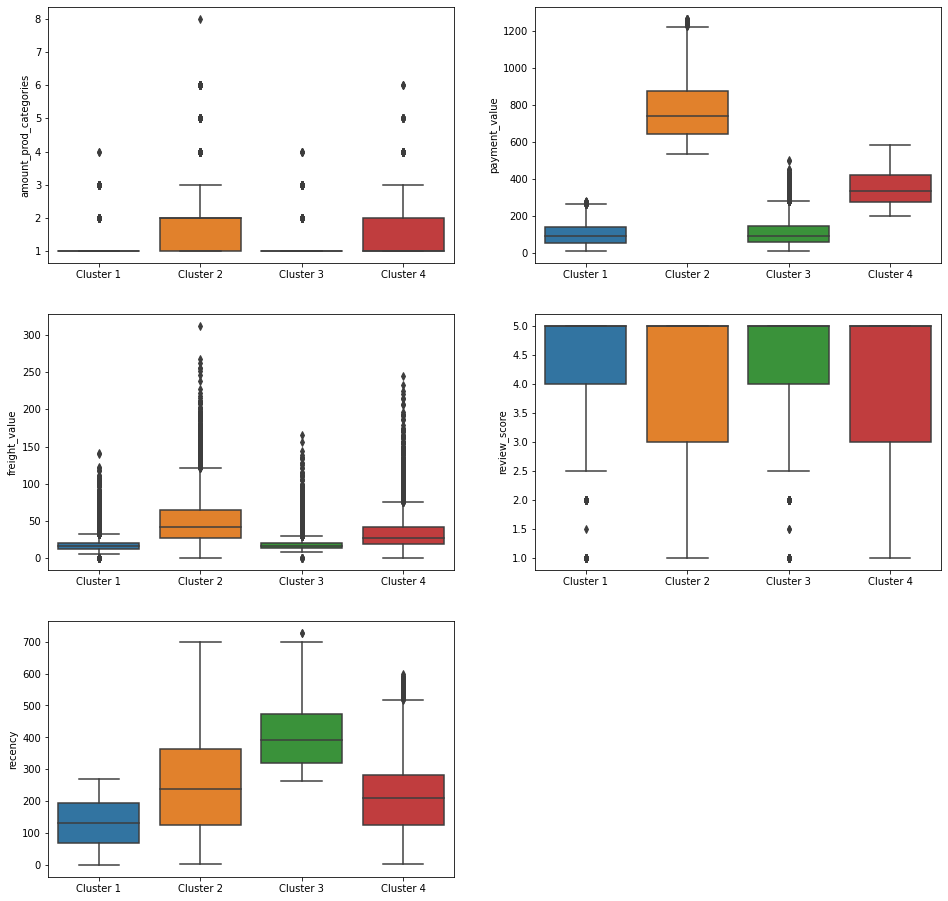

In [50]:
plt.figure(figsize=(16,16))



#sns.boxplot(x1, y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(321)
plt.xticks([])

sns.boxplot(x1, y0,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(322)
plt.xticks([])

sns.boxplot(x1, y1,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(323)
plt.xticks([])


sns.boxplot(x1, y2,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(324)
sns.boxplot(x1, y3,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')

plt.subplot(325)
sns.boxplot(x1, y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.show()

### 1.6  Verification of K-means stability

In [51]:
km = KMeans(n_clusters=4, init="random", random_state=10)
import time
time_start = time.time()
clusts_test1 = km.fit_predict(X_test)
print('K-Means done! Time elapsed: {} seconds'.format(time.time()-time_start))

K-Means done! Time elapsed: 0.06674003601074219 seconds


In [52]:
df_test_labeled = df_test.assign(cluster = clusts_test1)
df_test_labeled["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4"}, inplace=True)
df_test_labeled.head()

,0,1,2,3,4,cluster
0,1.0,113.15,13.25,3.0,285.0,Cluster 3
1,1.0,315.54,16.54,5.0,11.0,Cluster 2
2,1.0,194.81,19.51,4.0,519.0,Cluster 1
3,1.0,56.78,7.78,5.0,264.0,Cluster 3
4,1.0,131.51,21.61,4.0,209.0,Cluster 3


In [53]:
print (len(df_train_labeled["cluster"]))
(df_train_labeled["cluster"].value_counts()/len(df_train_labeled["cluster"]))*100

94834


Cluster 1    48.024970
Cluster 3    35.637008
Cluster 4    12.103254
Cluster 2     4.234768
Name: cluster, dtype: float64

In [54]:
print (len(df_test_labeled["cluster"]))
(df_test_labeled["cluster"].value_counts()/len(df_test_labeled["cluster"]))*100

1936


Cluster 3    42.407025
Cluster 1    27.737603
Cluster 2    24.896694
Cluster 4     4.958678
Name: cluster, dtype: float64

## 2 Clustering with K-Medoids

### 2.1 Initialization and modeling using pyclustering library

In [0]:

import time
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist
#D = cdist(X_train,X_train, metric='correlation')

In [56]:
sample = X_train
# Set random initial medoids.
initial_medoids = [10, 70, 520, 1005]
# Create instance of K-Medoids algorithm.
kmedoids_instance = kmedoids(sample.tolist(), initial_medoids)
time_start = time.time()
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
print('K-Medoid clustering done! Time elapsed: {} seconds'.format(time.time()-time_start))


K-Medoid clustering done! Time elapsed: 316.51096391677856 seconds


In [99]:
# Mediods found in above clustering, indexes are shown below.
kmedoids_instance.get_medoids()

[47170, 22256, 65430, 784]

### 2.2 building the cluster labels column

In [100]:

# Show allocated clusters.
print(type(clusters), len(clusters))
len(clusters[0])

<class 'list'> 4


29843

In [0]:
# create label list of the same size of each cluster list
firstmdclust = np.zeros(len(clusters[0])) + 1
secondmdclust = np.zeros(len(clusters[1])) + 2
thirdclust = np.zeros(len(clusters[2])) + 3
fourthmdclust =  np.zeros(len(clusters[3])) + 4
mdclust = np.concatenate((firstmdclust, secondmdclust, thirdclust, fourthmdclust ), axis=None) # get label lists to one signle list

In [0]:
import itertools
flatclust = itertools.chain.from_iterable(clusters) # get clusters lists joined to one list
flatclust = list(flatclust)

In [60]:
print(len(mdclust), len(flatclust)) # verify all is right shape

94834 94834


In [0]:
# creation of labels column according to clustering by using Pandas 

df_mdclust = pd.DataFrame(mdclust)
df_mdclust[1] = pd.DataFrame(flatclust)
df_mdclust = df_mdclust.rename(columns={0: 'labels', 1: 'value'})
df_mdclust = df_mdclust.sort_values(by=['value']).reset_index() # this gives us a label column with the right order


In [0]:
mdclusts_train = pd.Series(df_mdclust['labels']) # creation of numpy array from the ordered label column 

In [63]:
mdclusters = np.concatenate((mdclusts_train, clusts_test), axis=None) # add the test cluster
print(mdclusts_train.shape, clusts_test.shape ,mdclusters.shape) # verify all is right shape

(94834,) (1936,) (96770,)


In [64]:

from sklearn.metrics import silhouette_samples, silhouette_score

md_silhouette_avg = silhouette_score(X_train, mdclusts_train)
print ('silhouette coefficient for the above clustering = ', round(md_silhouette_avg, 2))


silhouette coefficient for the above clustering =  0.45


In [0]:
#X = np.asarray(X_train)
#from sklearn_extra.cluster import KMedoids
#kmedoids = KMedoids(n_clusters=3, random_state=42).fit(X)

### 2.3 Visualization with PCA

In [66]:
# Visualize clustering results.
df_PCA = df_PCA.assign(mdcluster = mdclusters)

df_PCA.columns

Index(['PCA_1', 'PCA_2', 'cluster', 'mdcluster'], dtype='object')

In [67]:
df_PCA['mdcluster'].unique()

array([ 4.,  3.,  1.,  2., 42.])

In [68]:
df_PCA["mdcluster"].replace({1: "Cluster 1", 2: "Cluster 2", 3: "Cluster 3", 4: "Cluster 4", 42: "Test values"}, inplace=True)
df_PCA.head()


,PCA_1,PCA_2,cluster,mdcluster
0,832.699107,51.037656,Cluster 2,Cluster 4
1,1091.605743,-64.378500,Cluster 2,Cluster 4
2,267.318904,-233.303386,Cluster 4,Cluster 3
3,609.901255,452.918387,Cluster 2,Cluster 4
4,996.413936,-123.249609,Cluster 2,Cluster 4


/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


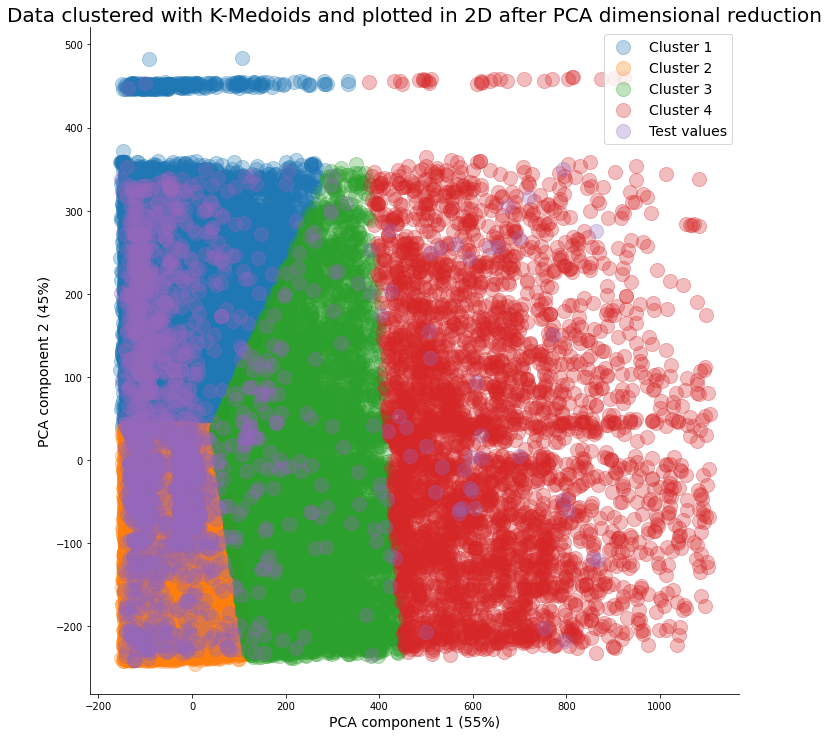

In [69]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Test values']
sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = df_PCA, fit_reg = False, legend = False, size = 10, hue = "mdcluster", hue_order= orderhue, scatter_kws={"s":200, "alpha":0.3} )
plt.xlabel('PCA component 1 (55%)', fontsize = 14)
plt.ylabel('PCA component 2 (45%)', fontsize = 14)
plt.title('Data clustered with K-Medoids and plotted in 2D after PCA dimensional reduction', fontsize = 20)
plt.legend(fontsize = 14)
plt.show()

In [70]:
df_train_labeled = df_train_labeled.assign(mdcluster = mdclusts_train)
df_train_labeled["mdcluster"].replace({1: "Cluster 1", 2: "Cluster 2", 3: "Cluster 3", 4: "Cluster 4"}, inplace=True)
df_train_labeled.head()

,amount_prod_categories,payment_value,freight_value,review_score,recency,cluster,mdcluster
0,8.0,992.96,93.84,5.0,288.0,Cluster 2,Cluster 4
1,6.0,1252.08,76.74,1.0,170.0,Cluster 2,Cluster 4
2,6.0,426.60,47.22,5.0,9.0,Cluster 4,Cluster 3
3,6.0,774.18,84.66,5.0,692.0,Cluster 2,Cluster 4
4,6.0,1157.04,61.24,5.0,112.0,Cluster 2,Cluster 4


In [0]:
x1 = df_train_labeled["mdcluster"]
y0 = df_train_labeled[df_train_labeled.columns[0]]
y1 = df_train_labeled[df_train_labeled.columns[1]]
y2 = df_train_labeled[df_train_labeled.columns[2]]
y3 = df_train_labeled[df_train_labeled.columns[3]]
y4 = df_train_labeled[df_train_labeled.columns[4]]
order = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]


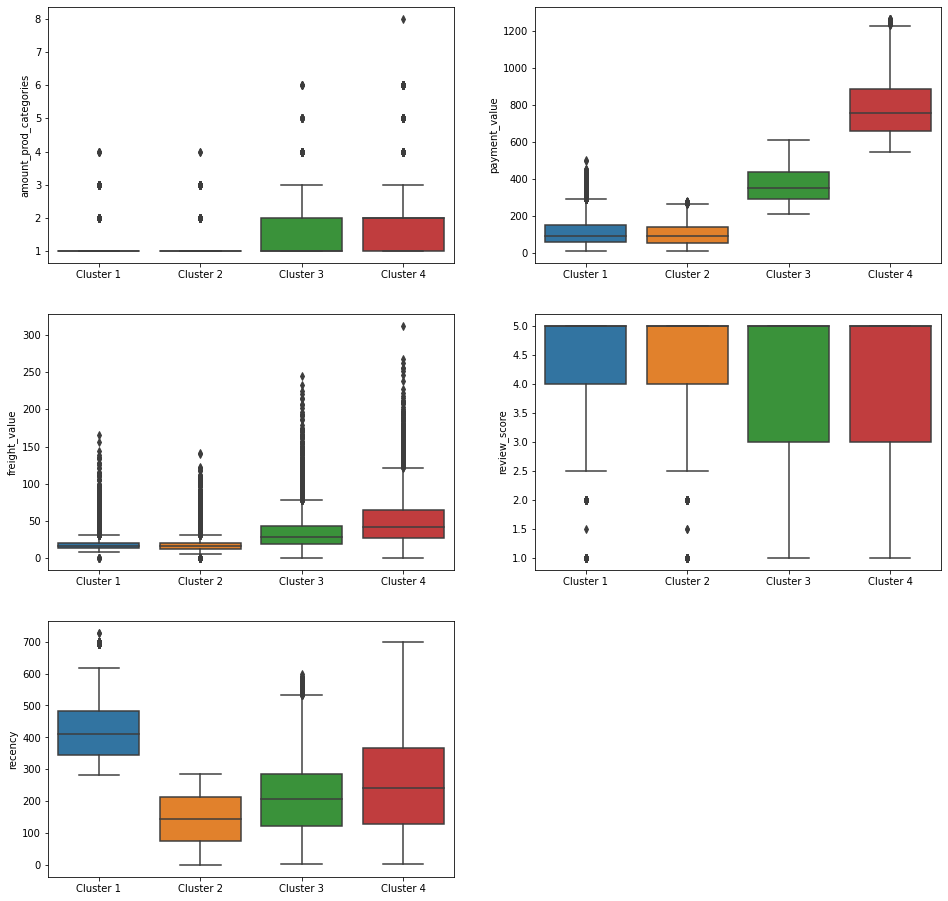

In [72]:
plt.figure(figsize=(16,16))



#sns.boxplot(x1, y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(321)
plt.xticks([])

sns.boxplot(x1, y0,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(322)
plt.xticks([])

sns.boxplot(x1, y1,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(323)
plt.xticks([])


sns.boxplot(x1, y2,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(324)
sns.boxplot(x1, y3,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')

plt.subplot(325)
sns.boxplot(x1, y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.show()

## 3 Clustering with DB-Scan algorythm

### 3.1 testing the optimal DB-Scan parameters

In [0]:
from sklearn import datasets # To import the sample dataset
from sklearn.preprocessing import StandardScaler # To transform the dataset
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning


In [74]:
eps_to_test = [0.01, 0.02]
min_samples_to_test = [10, 20, 75]
print("EPS VALUES:", eps_to_test)
print("MIN_SAMPLES:", min_samples_to_test)

EPS VALUES: [0.01, 0.02]
MIN_SAMPLES: [10, 20, 75]


In [0]:
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting ======================================================================
    
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric =============================================
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric ==============================================
    
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log ==========================================================================
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [0]:
# Average distance from closest K
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Number of cluster metrics dataframe
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [77]:
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Metrics computation
        noise_metric, cluster_metric = get_metrics(eps, min_samples, X_train, iter_)
        
        # Results in the respective dataframe
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.01 and min_samples =  10 | 4.321    6
  2 | Tested with eps = 0.01 and min_samples =  20 | 4.318    0
  3 | Tested with eps = 0.01 and min_samples =  75 | 4.318    0
  4 | Tested with eps = 0.02 and min_samples =  10 | 4.321    6
  5 | Tested with eps = 0.02 and min_samples =  20 | 4.318    0
  6 | Tested with eps = 0.02 and min_samples =  75 | 4.318    0


### 3.2 Grouping using optimized DB-Scan: select a combination with few clusters, similar to K-means

In [78]:
eps = 0.01
min_samples_to_test = 11
time_start = time.time()
dbscan_model = DBSCAN( eps = eps, min_samples = min_samples_to_test)

# Fitting
DBclusts_train = dbscan_model.fit(X_train)
print('DBScan done! Time elapsed: {} seconds'.format(time.time()-time_start))


DBScan done! Time elapsed: 0.6872477531433105 seconds


In [79]:
#Metrics calculation

noise_metric, cluster_metric = get_metrics(eps, min_samples_to_test, X_train, 1)


  1 | Tested with eps = 0.01 and min_samples =  11 |  4.32    3


In [80]:
DBclust = np.concatenate((DBclusts_train.labels_, clusts_test), axis=None)
print(clusts_test.shape ,DBclust.shape) # verify all is right shape
DBclust_series = pd.Series(DBclust) # transform to Pandas dataframe

(1936,) (96770,)


In [0]:
dbtrainvector = DBclusts_train.labels_


### 3.3 Representation in 2D using PCA

In [82]:
dfDB_PCA = df_PCA.assign(cluster = DBclust_series)

print(dfDB_PCA.columns, dfDB_PCA.shape)

Index(['PCA_1', 'PCA_2', 'cluster', 'mdcluster'], dtype='object') (96770, 4)


In [83]:
dfDB_PCA['cluster'].value_counts()

-1.0     94796
 42.0     1936
 1.0        14
 2.0        12
 0.0        12
Name: cluster, dtype: int64

In [84]:
dfDB_PCA = dfDB_PCA.dropna()
print(dfDB_PCA.columns, dfDB_PCA.shape)
dfDB_PCA['cluster'].unique()

Index(['PCA_1', 'PCA_2', 'cluster', 'mdcluster'], dtype='object') (96770, 4)


array([-1.,  0.,  1.,  2., 42.])

In [0]:
dfDB_PCA["cluster"].replace({ -1: "Cluster 0"}, inplace=True)


In [86]:
dfDB_PCA["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 4: "Cluster 5", 42: "Test values"}, inplace=True)

dfDB_PCA.head()

,PCA_1,PCA_2,cluster,mdcluster
0,832.699107,51.037656,Cluster 0,Cluster 4
1,1091.605743,-64.378500,Cluster 0,Cluster 4
2,267.318904,-233.303386,Cluster 0,Cluster 3
3,609.901255,452.918387,Cluster 0,Cluster 4
4,996.413936,-123.249609,Cluster 0,Cluster 4


In [87]:
dfDB_PCA['cluster'].value_counts()

Cluster 0      94796
Test values     1936
Cluster 2         14
Cluster 3         12
Cluster 1         12
Name: cluster, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


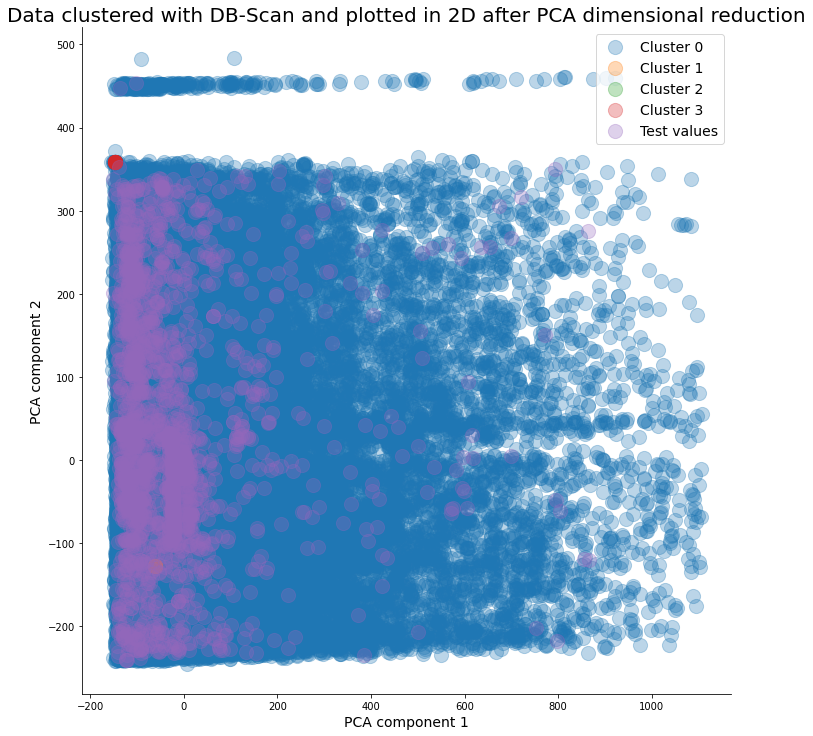

In [88]:
db_orderhue= ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3',  'Test values']
sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = dfDB_PCA, fit_reg = False, legend = False, size = 10, hue = "cluster", hue_order= db_orderhue, scatter_kws={"s":200, "alpha":0.3} )
plt.title('Data clustered with DB-Scan and plotted in 2D after PCA dimensional reduction' , fontsize = 20)
plt.xlabel('PCA component 1', fontsize = 14)
plt.ylabel('PCA component 2', fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

In [89]:
print

<function print>

In [90]:
df_train_labeled = df_train_labeled.assign(dbcluster = dbtrainvector)
df_train_labeled["dbcluster"].replace({-1: "Cluster 1", 0: "Cluster 2", 1: "Cluster 3", 2: "Cluster 4"}, inplace=True)
print(df_train_labeled["dbcluster"].unique())
df_train_labeled.head()

['Cluster 1' 'Cluster 2' 'Cluster 3' 'Cluster 4']


,amount_prod_categories,payment_value,freight_value,review_score,recency,cluster,mdcluster,dbcluster
0,8.0,992.96,93.84,5.0,288.0,Cluster 2,Cluster 4,Cluster 1
1,6.0,1252.08,76.74,1.0,170.0,Cluster 2,Cluster 4,Cluster 1
2,6.0,426.60,47.22,5.0,9.0,Cluster 4,Cluster 3,Cluster 1
3,6.0,774.18,84.66,5.0,692.0,Cluster 2,Cluster 4,Cluster 1
4,6.0,1157.04,61.24,5.0,112.0,Cluster 2,Cluster 4,Cluster 1


### 3.4 Boxplot for each feature

In [0]:
x2 = df_train_labeled["dbcluster"]
y0 = df_train_labeled[df_train_labeled.columns[0]]
y1 = df_train_labeled[df_train_labeled.columns[1]]
y2 = df_train_labeled[df_train_labeled.columns[2]]
y3 = df_train_labeled[df_train_labeled.columns[3]]
y4 = df_train_labeled[df_train_labeled.columns[4]]
order1 = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]



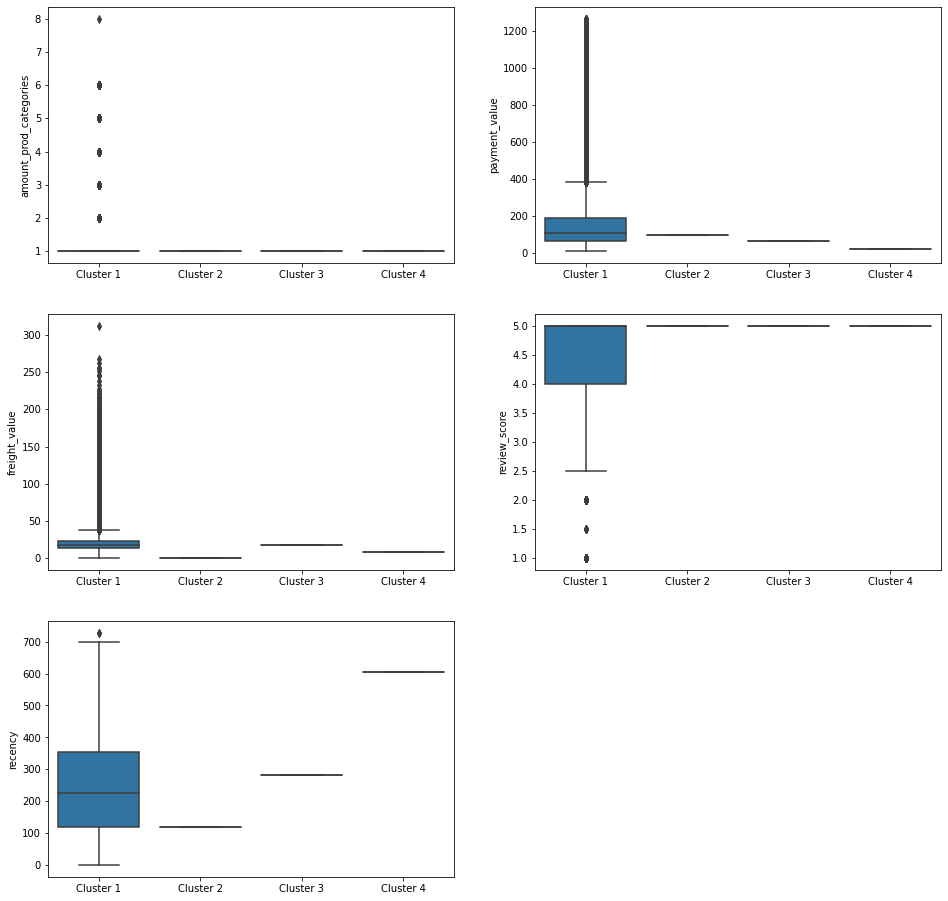

In [92]:
plt.figure(figsize=(16,16))





plt.xlabel('')
plt.subplot(321)
plt.xticks([])

sns.boxplot(x2, y0,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(322)
plt.xticks([])

sns.boxplot(x2, y1,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(323)
plt.xticks([])


sns.boxplot(x2, y2,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(324)
sns.boxplot(x2, y3,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')

plt.subplot(325)
sns.boxplot(x2, y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.show()

# Unsupervised segmentation of the RFM dataframe

In [93]:
df_RFM.head()

,Unnamed: 0,index,customer_id,frequency,recency,monetary_value,R,F,M,RFM Score,Segment
0,0,38753,b4afeb58ac51bc903c5362286c6a5cfe,8,288,992.96,2,5,5,255,can't lose
1,1,27611,08a0a61f98f22952682f7e463ef2d43e,6,170,1252.08,4,5,5,455,loyal customers
2,2,80902,cc3f0f9c25480b83c834bf8af1435a29,6,9,426.60,5,5,5,555,champions
3,3,5718,620732fed5579e0bdfdddee02aad4c54,6,692,774.18,1,5,5,155,can't lose
4,4,25363,109f80397e4897bbcf56313c25850332,6,112,1157.04,4,5,5,455,loyal customers


In [94]:
df_RFM['Segment'].unique()

array(["can't lose", 'loyal customers', 'champions', 'hibernating',
       'new customers', 'promising', 'about to sleep'], dtype=object)

In [95]:
X_RFM = df_RFM[['R','F', 'M']].values
scaler = preprocessing.StandardScaler()
#X_scaled = scaler.fit_transform(X) # variables normalized
#print(scaler.mean_)
#print(scaler.scale_)
X_RFM_scaled = scale(X_RFM)
print('X meanX',np.mean(X_RFM_scaled),',X standard deviation:',np.std(X_RFM_scaled), ".Ok, the features are scaled")

X meanX -1.9384445824187916e-17 ,X standard deviation: 1.0 .Ok, the features are scaled


2.1 Clustering by K-Means

In [96]:
km1 = KMeans(n_clusters=7, init="random", random_state=10)
import time
time_start = time.time()
clusts_RFM = km1.fit_predict(X_RFM_scaled)
print('K-Means done! Time elapsed: {} seconds'.format(time.time()-time_start))

K-Means done! Time elapsed: 0.452800989151001 seconds


In [97]:
df_RFM = df_RFM.assign(cluster = clusts_RFM)

df_RFM.head()

,Unnamed: 0,index,customer_id,frequency,recency,monetary_value,R,F,M,RFM Score,Segment,cluster
0,0,38753,b4afeb58ac51bc903c5362286c6a5cfe,8,288,992.96,2,5,5,255,can't lose,3
1,1,27611,08a0a61f98f22952682f7e463ef2d43e,6,170,1252.08,4,5,5,455,loyal customers,3
2,2,80902,cc3f0f9c25480b83c834bf8af1435a29,6,9,426.60,5,5,5,555,champions,3
3,3,5718,620732fed5579e0bdfdddee02aad4c54,6,692,774.18,1,5,5,155,can't lose,3
4,4,25363,109f80397e4897bbcf56313c25850332,6,112,1157.04,4,5,5,455,loyal customers,3


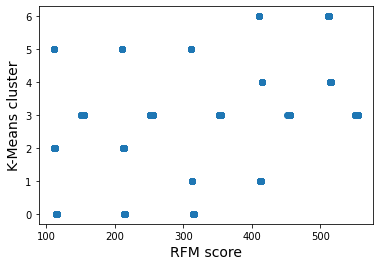

In [98]:
plt.scatter(df_RFM['RFM Score'],df_RFM['cluster'])
plt.xlabel('RFM score', fontsize = 14)
plt.ylabel('K-Means cluster', fontsize = 14)

plt.show()